In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb 
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

In [3]:
data = pd.read_parquet("./data/all_data.parquet")
print(data.shape)
data.head()

(60225, 11)


,crank_angle,total_pressure,mass_flow_rate,velocity,total_temp,UHTE,dynamic_viscosity,kinematic_viscosity,density,rpm,acceleration
0,-94.617905,1.164396,0.000028,0.062914,647.46550,1.034879,0.000031,0.000049,0.627783,800.0,22.073821
1,-94.235820,1.164366,0.000028,0.063364,647.45746,1.029407,0.000031,0.000049,0.627775,800.0,-8.270896
2,-93.853745,1.164344,0.000028,0.061991,647.45056,1.019855,0.000031,0.000049,0.627770,800.0,-23.753748
3,-93.471690,1.164333,0.000027,0.060847,647.44520,1.023269,0.000031,0.000049,0.627769,800.0,8.414226
4,-92.707630,1.164275,0.000029,0.065870,647.42926,1.035842,0.000031,0.000049,0.627753,800.0,5.454934


In [4]:
# define the target dataframe
y = data.UHTE

# columns to drop
cols_to_drop =["UHTE", "crank_angle",
"total_pressure", 
"total_temp", 
"mass_flow_rate", 
#"dynamic_viscosity", 
"density", 
"rpm",
#"acceleration"
]

# The inputs
X = data.drop(columns= cols_to_drop)
X.head()

,velocity,dynamic_viscosity,kinematic_viscosity,acceleration
0,0.062914,0.000031,0.000049,22.073821
1,0.063364,0.000031,0.000049,-8.270896
2,0.061991,0.000031,0.000049,-23.753748
3,0.060847,0.000031,0.000049,8.414226
4,0.065870,0.000031,0.000049,5.454934


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [6]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

In [47]:
regressor = xgb.XGBRegressor(
    n_estimators = 1000,
    max_depth = None
)

Wall time: 0 ns


In [48]:
%%time
regressor.fit(X_train, Y_train)

Wall time: 1min 11s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
importance_df = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = X.columns)
importance_df.head()

,velocity,dynamic_viscosity,kinematic_viscosity,acceleration
0,0.159692,0.053104,0.217199,0.570005


In [50]:
predictions = regressor.predict(X_test)
mse = skm.mean_squared_error(Y_test, predictions)
mse

0.0023935588171992038

In [58]:
speed = 3000
test_data = pd.read_parquet(f"./data/each_speed_parquets/1cy_anechoic_{speed}.parquet")
test_data = test_data.drop(columns=[
    #"UHTE", "crank_angle",
"total_pressure", 
"total_temp", 
"mass_flow_rate", 
#"dynamic_viscosity", 
"density", 
"rpm",
"time",
#"acceleration"

])
test_input = test_data.drop(columns = ["crank_angle", "UHTE"])
test_input.head()

,velocity,dynamic_viscosity,kinematic_viscosity,acceleration
0,12.407100,0.000029,0.000029,-2065.736711
1,12.292513,0.000029,0.000029,-2058.217644
2,12.178540,0.000029,0.000029,-2043.632711
3,12.065473,0.000029,0.000029,-2027.411511
4,11.953182,0.000029,0.000029,-2016.053251


In [59]:
test_predictions = regressor.predict(test_input)
test_data["predictions"] = test_predictions
test_data.head()

,crank_angle,velocity,UHTE,dynamic_viscosity,kinematic_viscosity,acceleration,predictions
0,-94.0,12.407100,1.0,0.000029,0.000029,-2065.736711,0.998915
1,-93.0,12.292513,1.0,0.000029,0.000029,-2058.217644,1.000468
2,-92.0,12.178540,1.0,0.000029,0.000029,-2043.632711,1.001183
3,-91.0,12.065473,1.0,0.000029,0.000029,-2027.411511,1.000026
4,-90.0,11.953182,1.0,0.000029,0.000029,-2016.053251,0.996678


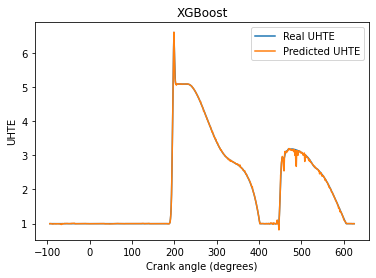

In [60]:
plt.plot(test_data.crank_angle, test_data.UHTE, label="Real UHTE")
plt.plot(test_data.crank_angle, test_data.predictions, label="Predicted UHTE")
plt.legend(loc="best")
plt.xlabel("Crank angle (degrees)")
plt.ylabel("UHTE")
plt.title("XGBoost")
plt.savefig(f"./output_graphs/xgboost_uhte_comparison_{speed}_rpm.png")
plt.show()